JBCA Hack Night. Here we have satellite images of Puerto Rico from Sentinel-1, taken on 3 dates - before, immediately after, and a month after Hurricane Maria in 2017. The data is from the SAR detector (radio frequency), and two orthogonal polarisations are recorded. See https://github.com/joe-fennell/hacknight_1 for the more information, and the initial challenges / scripts supplied for this Hack Night.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster, preprocessing
%matplotlib inline

In [2]:
data = {'16/09/17':np.load('hacknight_1-master/data/SARim1_16_09_2017.npy'),
        '22/09/17':np.load('hacknight_1-master/data/SARim2_22_09_2017.npy'),
        '22/10/17':np.load('hacknight_1-master/data/SARim3_22_10_2017.npy')}
print(data['16/09/17'].shape)

(2000L, 4940L, 3L)


Each day contains 3 images, one for each of two polarisations, and one for (polarisation_0 / polarisation_1). We can look at one of the polarisation images for each day below:

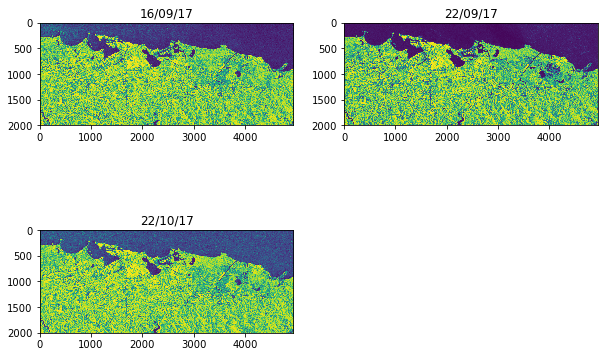

In [3]:
f = plt.figure(figsize = (10,7))
for i,j in enumerate(data.items()):
    f.add_subplot(2,2,i+1)
    plt.imshow(j[1][:,:,0])
    plt.title(j[0])
plt.show()

Now let's have a look at all 3 images for the first day:

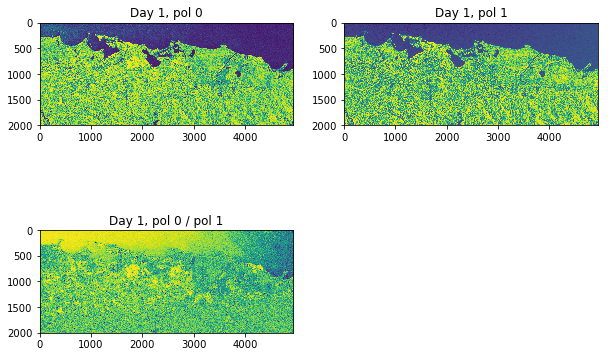

In [4]:
f = plt.figure(figsize = (10,7))
for i in range(2):
    f.add_subplot(2,2,i+1)
    plt.imshow(data['16/09/17'][:,:,i])
    plt.title('Day 1, pol '+str(i))
f.add_subplot(2,2,3)
plt.imshow(data['16/09/17'][:,:,2])
plt.title('Day 1, pol 0 / pol 1')
plt.show()

## Classification

Idea is to try and use an unsupervised clustering algorithm to indentify land vs. water regions.

Let's try a simple case where we just input individual pixels into a 2-cluster K-means algorithm. Note that we can make use of the dual-polarisation (i.e. for each sample - pixel position - we actually have 2 features - pixel intensities - one for each polarisation).

Here we cluster just the data from the first day:

In [5]:
def multi_to_2d(arr):
    """ convert image array to 1D arrays"""
    s = arr.shape
    return np.ravel(arr, (0)).reshape((-1, s[2]))

im_2D = multi_to_2d(data['16/09/17'][:,:,:2])
im_2D.shape

(9880000L, 2L)

In [6]:
# robust scale the pixels for each polarisation, i.e. centre to median and normalise using interquartile range
im_2D = preprocessing.robust_scale(im_2D)

In [7]:
# construct a KMeans clustering object
clus = cluster.KMeans(n_clusters=2)

In [8]:
# perform clustering operation
## returns a list of cluster IDs
day1_clusters = clus.fit_predict(im_2D)

In [9]:
# reshape the cluster vector to a
# 2D array for plotting

day1_clusters = day1_clusters.reshape(data['16/09/17'].shape[:-1])
day1_clusters

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

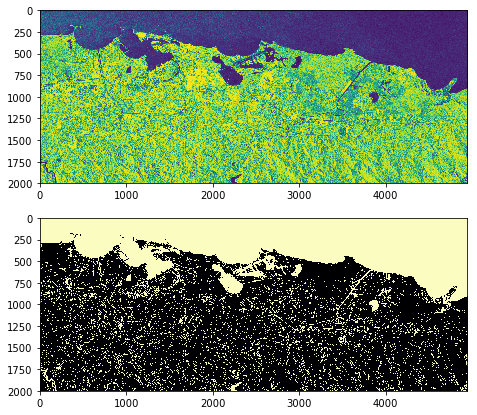

In [10]:
f = plt.figure(figsize = (10,7))
f.add_subplot(2,1,1)
plt.imshow(data['16/09/17'][:,:,0])
f.add_subplot(2,1,2)
plt.imshow(day1_clusters, 'magma')
plt.show()

Now we use the model from above to classify day 2:

In [11]:
im_2D_day2 = multi_to_2d(data['22/09/17'][:,:,:2])
im_2D_day2 = preprocessing.robust_scale(im_2D_day2)
day2_clusters = clus.predict(im_2D_day2)
day2_clusters = day2_clusters.reshape(data['22/09/17'].shape[:-1])

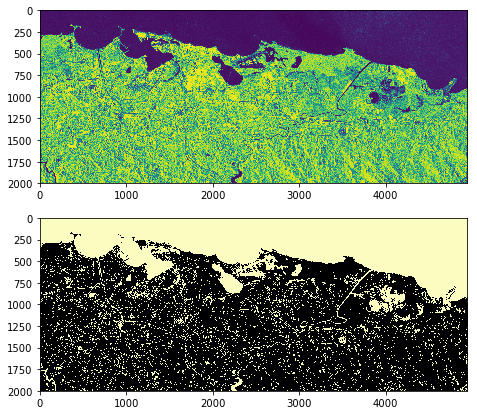

In [12]:
f = plt.figure(figsize = (10,7))
f.add_subplot(2,1,1)
plt.imshow(data['22/09/17'][:,:,0])
f.add_subplot(2,1,2)
plt.imshow(day2_clusters, 'magma')
plt.show()

Now, to highlight regions of excess water in day 2, relative to day 1 (pre-hurricane), we can subtract the classified day 1 from day 2:

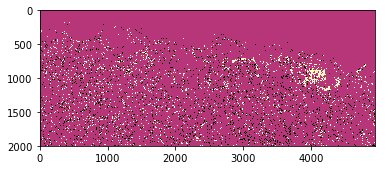

In [13]:
diff_day1_day2 = day2_clusters - day1_clusters
plt.imshow(diff_day1_day2, 'magma')
plt.show()

We can see that the main areas of flooding (e.g. (1000, 4000)) are highlighted here, but there's a lot of noise all over the difference image. This is no doubt due to us using individual pixels as input into the clustering algorithm. A way that we can try get around this is to group blocks of alike pixels:

## Grouping pixels / image segmentation

see: https://github.com/TMCantwell/JEDI/blob/master/Image_segmetaion_Kmeans_tutorial.ipynb

Here we zoom into a smaller section of the image as a start. We look at the airport region near the coast. Note from the above single pixel classification, the airport tarmac is grouped into the same cluster as the water regions -- presumably due to it being smooth and having similar reflective properties. This suggest that we may need 3 (or more) clusters to better represent to groupings that we are aiming for (i.e. water vs land).

(663L, 954L, 3L)


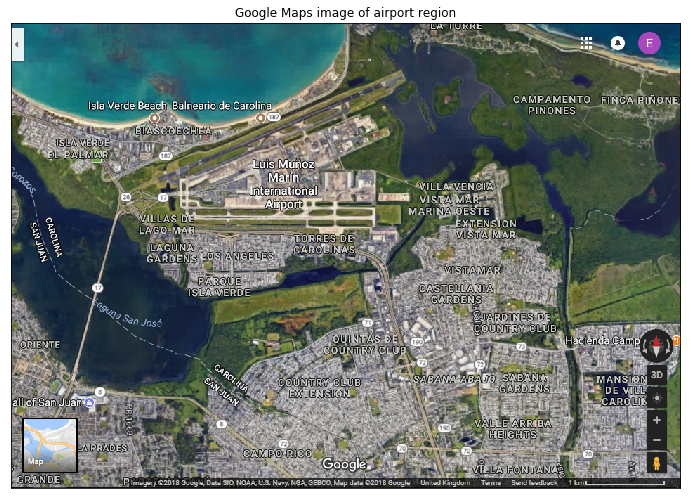

In [14]:
airport_gmaps = imread('Google_maps_airport_region.png')
print airport_gmaps.shape
plt.figure(figsize=(12,9))
plt.imshow(airport_gmaps)
plt.title('Google Maps image of airport region')
plt.xticks([])
plt.yticks([])
plt.show()

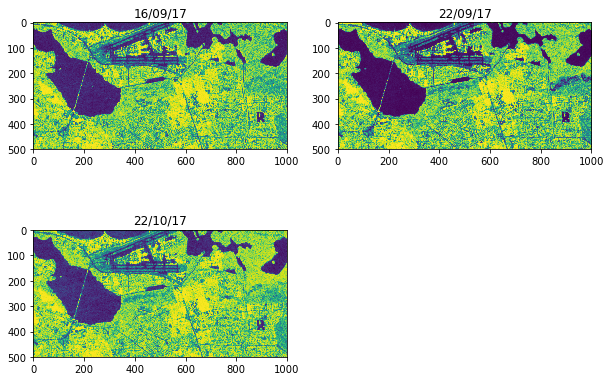

In [15]:
f = plt.figure(figsize = (10,7))
for i,j in enumerate(data.items()):
    f.add_subplot(2,2,i+1)
    plt.imshow(j[1][500:1000,2000:3000,0])
    plt.title(j[0])
plt.show()